## Fetch data

In [2]:
import pandas as pd
meta = pd.read_csv('AnonDB.csv')
df_pixel_stats = pd.read_csv('pixel_stats.csv')



In [14]:
df = df_pixel_stats.copy()

df["base_id"] = (
    df["nama_gambar"]
    .str.replace("_80_wrp.tiff", "", regex=False)
    .str.replace("_20_wrp.tiff", "", regex=False)
)


In [16]:
df_80 = df[df["nama_gambar"].str.contains("_80_wrp.tiff")].copy()
df_20 = df[df["nama_gambar"].str.contains("_20_wrp.tiff")].copy()


In [17]:
df_80 = df_80.rename(columns={
    "mean": "mean_80",
    "median": "median_80",
    "modus": "modus_80"
})

df_20 = df_20.rename(columns={
    "mean": "mean_20",
    "median": "median_20",
    "modus": "modus_20"
})


In [18]:
df_final = pd.merge(
    df_80[["base_id", "mean_80", "median_80", "modus_80"]],
    df_20[["base_id", "mean_20", "median_20", "modus_20"]],
    on="base_id",
    how="inner"
)


In [24]:
df_final.head()

,base_id,mean_80,median_80,modus_80,mean_20,median_20,modus_20
0,10084_35_1_01272020,67.735187,70.0,70,89.951571,95.0,102
1,10084_35_1_02222021,72.874862,85.0,6,88.351796,105.0,5
2,10085_35_1_01272020,64.001961,65.0,63,82.821786,86.0,77
3,10085_35_1_02222021,70.857794,82.0,6,86.758040,100.0,5
4,10105_24_3_03012021,91.260262,101.0,104,103.576085,116.0,8


In [20]:
# --- Calculate Performance Ratio (PR) ---
meta['PR'] = meta['Pmp_(W)'] / meta['Nameplate_Pmp_(W)'] * 100

In [31]:
meta2 = meta.copy()

meta2["base_id"] = (
    meta2["ELHPath"]
        .str.split("/")            # pisah folder
        .str[-1]                   # ambil nama file
        .str.replace(".tiff", "", regex=False)
        .str.replace("_80", "", regex=False)
        .str.replace("_20", "", regex=False)
)


In [32]:
# --- Calculate Performance Ratio (PR) ---
meta2['PR'] = meta2['Pmp_(W)'] / meta2['Nameplate_Pmp_(W)'] * 100

In [ ]:
# -- Merge Meta2 with the pixel stats ---
meta_merged = meta2.merge(
    df_final,
    on="base_id",
    how="left"
)


In [ ]:
cols = [
    "PR",
    "mean_80", "median_80", "modus_80",
    "mean_20", "median_20", "modus_20"
]

correlation_matrix = meta_merged[cols].corr()

print(correlation_matrix["PR"].sort_values(ascending=False))


PR           1.000000
median_80    0.309684
mean_80      0.302513
modus_80     0.250620
modus_20     0.234074
median_20    0.062047
mean_20      0.049778
Name: PR, dtype: float64


In [ ]:
pd.set_option('display.max_columns', None)

print(meta_merged.columns.tolist())

['Unnamed: 0', 'Mod_ID', 'Confidential', 'Make', 'Model', 'Interconnect_Tech', 'Module_Area_(cm2)', 'Junction_Box_Type', 'Cell_Wafer_Type', 'Cell_Tech', 'Cell_Area_(cm2)', 'Total_Exposure', 'Nameplate_Isc_(A)', 'Nameplate_Voc_(V)', 'Nameplate_Imp_(A)', 'Nameplate_Vmp_(V)', 'Nameplate_Pmp_(W)', 'Isc_(A)', 'Voc_(V)', 'Imp_(A)', 'Vmp_(V)', 'Pmp_(W)', 'FF_(percent)', 'Measured_Temperature_(C)', 'Temp_Measurement_Method', 'Voltage_Temperature_Coefficient_(mV/C)', 'Simulator_Make', 'Simulator_Model', 'IV_Date', 'IV_Time', 'IV_Lab_Location', 'Camera_Make', 'Camera_Model', 'Detector_Type', 'Image_Resolution_(MP)', 'Longpass_Filter_Wavelength_(nm)', 'High_Applied_Current_(A)', 'High_Applied_Voltage_(V)', 'High_Sensor_Exposure_Time_(s)', 'Low_Applied_Current_(A)', 'Low_Applied_Voltage_(V)', 'Low_Sensor_Exposure_Time_(s)', 'ISO', 'Aperture', 'High_Temperature_(C)', 'Low_Temperature_(C)', 'Working_Distance_(m)', 'High_EL_Date', 'High_EL_Time', 'Low_EL_Date', 'Low_EL_Time', 'EL_Lab_Location', 'ELHP

In [54]:
meta_filtered = meta_merged[
    (meta_merged["PR"] > 0) & (meta_merged["PR"] <= 100)
].copy()


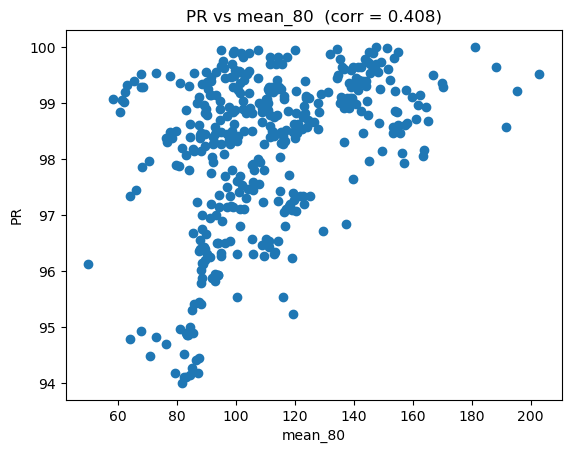

In [60]:
import matplotlib.pyplot as plt

# Tentukan variabel yang mau diplot
x_var = "mean_80"
y_var = "PR"

corr_value = meta_filtered[[x_var, y_var]].corr().iloc[0,1]

plt.scatter(meta_filtered[x_var], meta_filtered[y_var])
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.title(f"{y_var} vs {x_var}  (corr = {corr_value:.3f})")
plt.show()



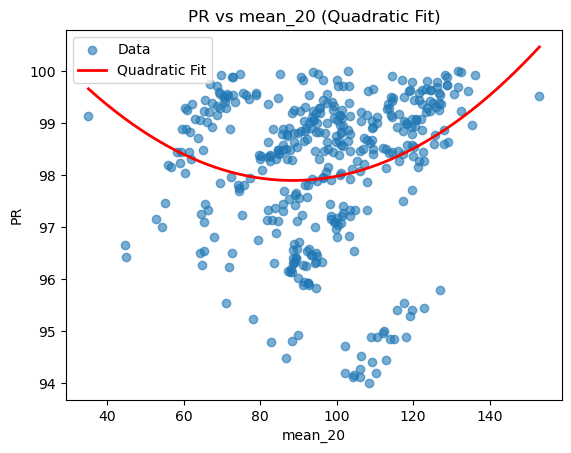

Quadratic equation:
PR = 0.000617*x^2 + -0.109250*x + 102.727634


In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Tentukan variabel
x_var = "mean_20"
y_var = "PR"

# Ambil data dan buang NaN
data = meta_filtered[[x_var, y_var]].dropna()
x = data[x_var].values
y = data[y_var].values

# ==============================
# Polynomial fit degree 2 (quadratic)
# ==============================
coeffs = np.polyfit(x, y, 2)   # Least squares
poly = np.poly1d(coeffs)

# Buat x smooth untuk kurva
x_smooth = np.linspace(x.min(), x.max(), 200)
y_smooth = poly(x_smooth)

# ==============================
# Plot
# ==============================
plt.scatter(x, y, alpha=0.6, label="Data")
plt.plot(x_smooth, y_smooth, color="red", linewidth=2, label="Quadratic Fit")

plt.xlabel(x_var)
plt.ylabel(y_var)
plt.title(f"{y_var} vs {x_var} (Quadratic Fit)")
plt.legend()

plt.show()

# ==============================
# Print persamaan
# ==============================
a, b, c = coeffs
print(f"Quadratic equation:")
print(f"{y_var} = {a:.6f}*x^2 + {b:.6f}*x + {c:.6f}")
